In [1]:
import numpy as np # numpy for multidimensional arrays, store imaging data, vector fields, etc.
import matplotlib.pyplot as plt # displaying images, and triangulated surfaces
# interactive plots
%matplotlib notebook

# to draw 3D triangulated surfaces
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

plt.set_loglevel('critical') # avoid printing a bunch of unnecessary warning messages

# Registering point sets

# get filenames

In [2]:
# 38 landmarks, each landmark is a position in 3D
landmarks0 = 'hippocampus_06_landmarks.txt'
landmarks1 = 'hippocampus_08_landmarks.txt'

# for visualization, we'll use triangulated surfaces
# lists of vertices, and lists of faces that connect vertices into triangles
surface0 = 'hippocampus_06_surface.byu'
surface1 = 'hippocampus_08_surface.byu'

# Define functions for reading data

Triangulated surfaces always store data as a list of vertices (points in 3D),

and a list of faces (triples of integers), each triple says which vertices should be connected into a triangle.

In [3]:
def read_surface(filename):
    ''' Read riangulated surface data
    .byu format (Brigham Young University) has slightly different headers.
    '''
    v = []
    f = []
    with open(filename,'rt') as file:
        for i,line in enumerate(file):
            # How many faces and vertices are there?
            if filename.endswith('.txt'):
                if i == 0:
                    nv,nf = [int(l) for l in line.split()]
                    continue
            elif filename.endswith('.byu'):
                if i == 0:
                    _,nv,nf,_ = [int(l) for l in line.split()]
                    continue
                elif i == 1:                    
                    continue
                    
            # loop through all the lines and grab all the vertices in a list
            if len(v) < nv:
                v.append( [float(l) for l in line.split()])
            else:
                # we'll loop through all the lines and grab the faces in a list
                f.append([abs(int(l)) for l in line.split()])
    
    if filename.endswith('.byu'):
        # indexing starting at 0 (python's convention)
        # indexing start at 1 (matlab's convention)
        # we need to subtract the value 1 from all these faces, to follow python's convention
        f = np.array(f) - 1
    return np.array(v),np.array(f)

In [4]:
def read_landmarks(filename):
    q = []
    with open(filename,'rt') as f:
        for i,line in enumerate(f):
            # the first line tells us how many points there are and in how many dimensions
            if i == 0:
                nd,nl = [int(l) for l in line.split()] # how many dimensions, how many landmarks
                continue
            # loop through every line in the text file and grab the vertices in a list
            q.append([float(l) for l in line.split()])
    return np.array(q)

# define some functions for drawing data

In [5]:
def lim_from_v(v):
    ''' Get a bounding box around our data, with equal aspect ratio, for drawing
    '''
    m = np.min(v,0)
    M = np.max(v,0)
    c = (m+M)/2
    d = (M-m)/2
    d = np.max(d)
    xlim = (c[0]-d,c[0]+d)
    ylim = (c[1]-d,c[1]+d)
    zlim = (c[2]-d,c[2]+d)
    return xlim,ylim,zlim


In [6]:
def get_face_normals(v,f,normalize=True):
    ''' for lighting calculations, or for coloring a surface, we find normals.'''
    n = np.cross( v[f[:,1]] - v[f[:,0]] , v[f[:,2]] - v[f[:,0]])/2 # magnitude is area of face
    if normalize:
        n = n / np.sqrt(np.sum(n**2,-1,keepdims=True)) # direction, not magnitude
    return n

# draw the first surface

<IPython.core.display.Javascript object>


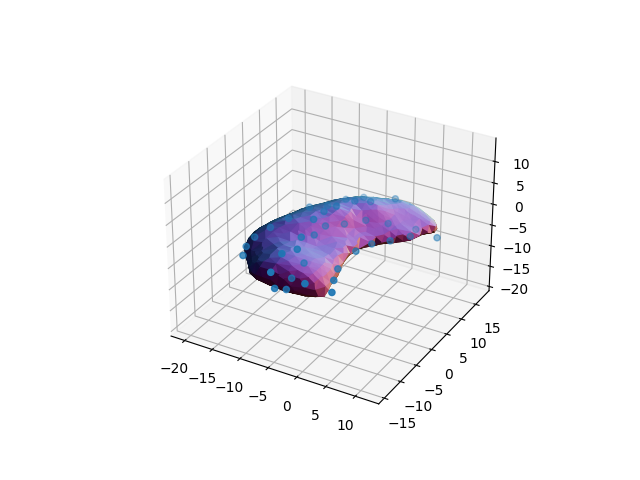

In [7]:
v0,f0 = read_surface(surface0)
q0 = read_landmarks(landmarks0)


# shift all my vertices and landmark points by a little bit
# because we'd like to estimate an unknown shift.
# this data has already been shifted so it's center of mass is at the origin
off = -5
v0 += off
q0 += off



# quick visualization
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# compute the face normal
n0 = get_face_normals(v0,f0)
ambient = 0.3 # every face has a bit of light
diffuse = 0.7 # faces oriented toward a light source will be brighter
direction = np.array([1.0,1.0,1.0])/np.sqrt(3.0) # normalized to unit length

# use the normals to color the surface
color = n0*0.5+0.5 # scale from (-1, 1) to  (0, 1)
# direction of the light source (normalized vector)


# build our triangulated surface using matplotlib
mesh0 = Poly3DCollection(v0[f0],color=color*(diffuse*np.clip(n0@direction,0,1) + ambient)[...,None])
ax.add_collection3d(mesh0)

xlim,ylim,zlim = lim_from_v(v0)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)

ax.scatter(*q0.T)

# draw the second surface

<IPython.core.display.Javascript object>


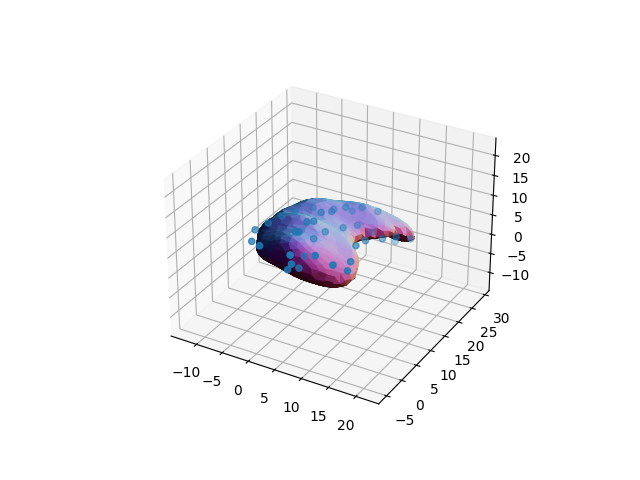

In [8]:
v1,f1 = read_surface(surface1)
q1 = read_landmarks(landmarks1)
off = 5
v1 += off
q1 += off
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
n1 = get_face_normals(v1,f1)
color = n1*0.5+0.5
mesh1 = Poly3DCollection(v1[f1],color=color*(diffuse*np.clip(n1@direction,0,1) + ambient)[...,None])
ax.add_collection3d(mesh1)
xlim,ylim,zlim = lim_from_v(v1)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)

ax.scatter(*q1.T)

# draw them together

<IPython.core.display.Javascript object>


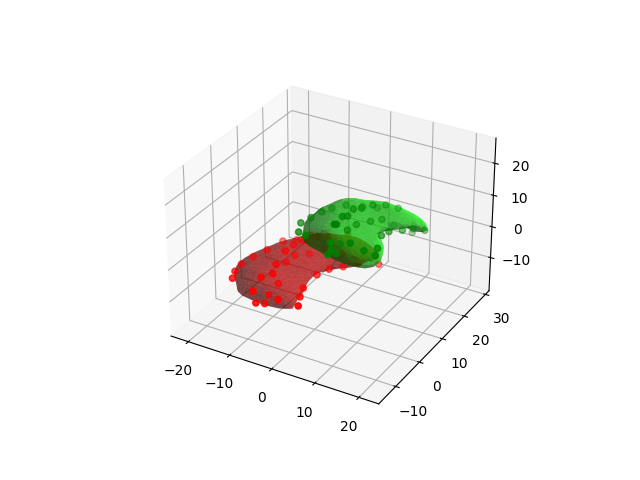

In [9]:
# draw them together
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
color = np.array([1.0,0.0,0.0])
mesh0_ = Poly3DCollection(v0[f0],color=color*(diffuse*np.clip(n0@direction,0,1) + ambient)[...,None],alpha=0.5,edgecolor='none')
ax.add_collection3d(mesh0_)

color = np.array([0.0,1.0,0.0])
mesh1_ = Poly3DCollection(v1[f1],color=color*(diffuse*np.clip(n1@direction,0,1) + ambient)[...,None],alpha=0.5,edgecolor='none')
ax.add_collection3d(mesh1_)

xlim,ylim,zlim = lim_from_v(np.concatenate((v0,v1)))
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)

ax.scatter(*q0.T,c='r')
ax.scatter(*q1.T,c='g')

# how close are the landmarks?

In [10]:
# we'll calculate the sum of square error
E0 = 0.5*np.sum((q0-q1)**2)
print(f'Initial sum of square error {E0}')

Initial sum of square error 5017.367354352558


# Align by translation
Aligning by translation means aligning center of mass.

In [11]:
c0 = np.mean(q0,0)
c1 = np.mean(q1,0)
T =  c1 - c0
print(T)

[ 8.63194089 10.04134255  8.62328863]


In [12]:
# apply this transformation to our data (landmark points and surface vertices)
Tq0 = q0 + T
Tv0 = v0 + T

<IPython.core.display.Javascript object>


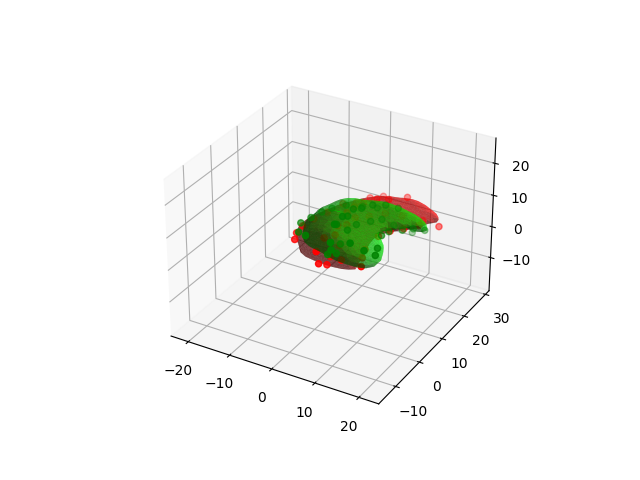

In [13]:
# draw them together
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
color = np.array([1.0,0.0,0.0])
mesh0_ = Poly3DCollection(Tv0[f0],color=color*(diffuse*np.clip(n0@direction,0,1) + ambient)[...,None],alpha=0.5,edgecolor='none')
ax.add_collection3d(mesh0_)

color = np.array([0.0,1.0,0.0])
mesh1_ = Poly3DCollection(v1[f1],color=color*(diffuse*np.clip(n1@direction,0,1) + ambient)[...,None],alpha=0.5,edgecolor='none')
ax.add_collection3d(mesh1_)

xlim,ylim,zlim = lim_from_v(np.concatenate((v0,v1)))
xlimsave = xlim
ylimsave = ylim
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)

ax.scatter(*Tq0.T,c='r')
ax.scatter(*q1.T,c='g')

In [14]:
ET = 0.5*np.sum((Tq0-q1)**2)
print(f'Sum of square error after translation {ET}')

Sum of square error after translation 273.0660111848239


# compute a linear transform

In [15]:
# resize my data, D X N arrays (D = 3 dimensions, and N = 38 landmarks)
# assume that we've shifted our datasets to the origin
X = (q0 - c0).T
Y = (q1 - c1).T
# to estimate an optimal transform
# we take Y (our green landmarks)
# and multiply on the right by the pseudoinverse of X
# X^T (XX^T)^{-1}
# "cross covariance  times inverse coverance "
L = (Y@X.T)@np.linalg.inv(X@X.T)
print(L)

[[ 0.93675552 -0.16225414 -0.06597626]
 [ 0.18808443  1.04012692  0.15778684]
 [-0.05998135 -0.30512201  0.92586976]]


In [16]:
# apply transformation to our data (data that has already been shifted to origin)
Lq0 = (L@X).T
Lv0 = (L@(v0-c0).T).T

<IPython.core.display.Javascript object>


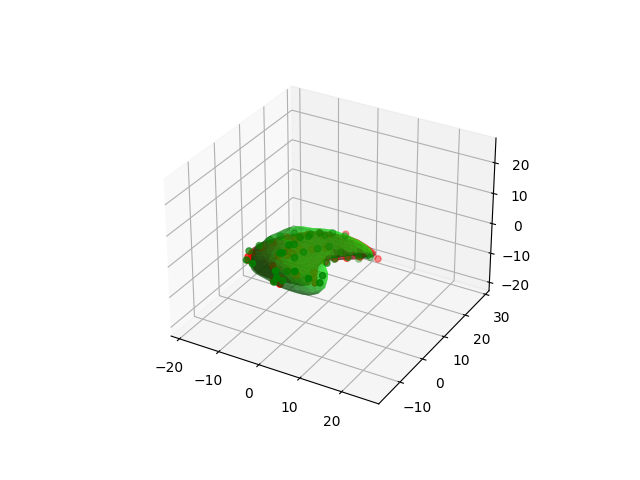

In [17]:
# draw them together
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
color = np.array([1.0,0.0,0.0])
Ln0 = get_face_normals(Lv0,f0)
mesh0_ = Poly3DCollection(Lv0[f0],color=color*(diffuse*np.clip(Ln0@direction,0,1) + ambient)[...,None],alpha=0.5,edgecolor='none')
ax.add_collection3d(mesh0_)

color = np.array([0.0,1.0,0.0])

mesh1_ = Poly3DCollection((v1-c1)[f1],color=color*(diffuse*np.clip(n1@direction,0,1) + ambient)[...,None],alpha=0.5,edgecolor='none')
ax.add_collection3d(mesh1_)

xlim,ylim,zlim = lim_from_v(np.concatenate((Lv0,v1)))
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)

ax.scatter(*Lq0.T,c='r')
ax.scatter(*(q1-c1).T,c='g')

In [18]:
EL = 0.5*np.sum((L@X-Y)**2)
print(f'Sum of square error after linear {EL}')

Sum of square error after linear 22.67229438427689


# Compute an affine transform

Recall in homogeneous coordinates, every vector needs the number 1 padded to the end.

Transformations are matrices where linear part is in top left corner, translation 
is in the top right corner, and the bottom row is always 0,0,0,1 (in 3D).

In [19]:
X = q0.T
X = np.concatenate((X,np.ones((1,X.shape[-1]))))

Y = q1.T
Y = np.concatenate((Y,np.ones((1,X.shape[-1]))))

# compute exactly the same equation as above (Y times pseudoinverse of X)
A = (Y@X.T)@np.linalg.inv(X@X.T)
print(A)
Asave3d = A
# note the bottom row is ALMOST 0,0,0,1
# 

[[ 9.36755520e-01 -1.62254140e-01 -6.59762629e-02  8.35934711e+00]
 [ 1.88084426e-01  1.04012692e+00  1.57786837e-01  1.14214350e+01]
 [-5.99813453e-02 -3.05122006e-01  9.25869764e-01  8.56445126e+00]
 [-1.56125113e-17  3.03576608e-18  5.20417043e-17  1.00000000e+00]]


In [20]:
# apply this affine transform to our data 
Aq0 = (A[:3,:3]@q0.T).T + A[:3,-1] # matrix multiplication with linear, then add translation
Av0 = (A[:3,:3]@v0.T).T + A[:3,-1]

<IPython.core.display.Javascript object>


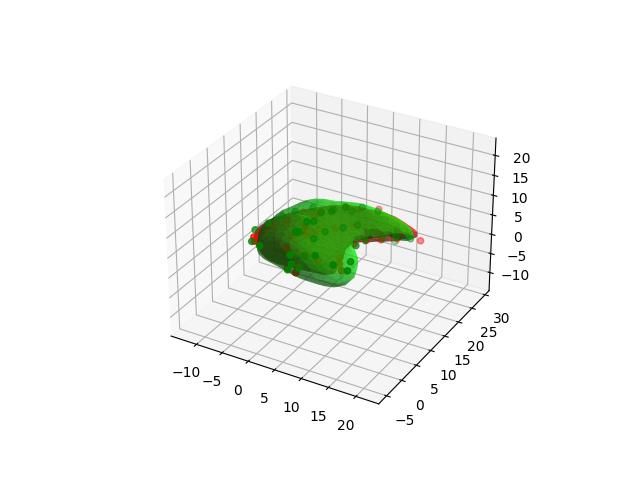

In [21]:
# draw them together
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
color = np.array([1.0,0.0,0.0])
An0 = get_face_normals(Av0,f0)
mesh0_ = Poly3DCollection(Av0[f0],color=color*(diffuse*np.clip(An0@direction,0,1) + ambient)[...,None],alpha=0.5,edgecolor='none')
ax.add_collection3d(mesh0_)

color = np.array([0.0,1.0,0.0])

mesh1_ = Poly3DCollection(v1[f1],color=color*(diffuse*np.clip(n1@direction,0,1) + ambient)[...,None],alpha=0.5,edgecolor='none')
ax.add_collection3d(mesh1_)

xlim,ylim,zlim = lim_from_v(np.concatenate((Av0,v1)))
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)

ax.scatter(*Aq0.T,c='r')
ax.scatter(*q1.T,c='g')

In [22]:
EA = 0.5*np.sum((A@X-Y)**2)
print(f'Sum of square error after affine {EA}')

Sum of square error after affine 22.672294384276885


# Estimating Rotations to align sets of landmarks

If a person takes two images in two different scanners, their pose will be different, but their size and shape will be exactly the same.

In [23]:
# create X and Y vectors that are centered at the origin and are DxN where D=3 dimensions, N=38 landmarks
X = (q0 - c0).T
Y = (q1 - c1).T

# form cross covariance matrix X Y^T
# and calculate its singular value decomposition
Sigma = X@Y.T
u,s,vh = np.linalg.svd(Sigma)
# estimate an orthogonal/aka rigid linear transform, 
R = vh.T@u.T

In [24]:
# apply to landmark points and surface vertices
Rq0 = (R@X).T 
Rv0 = (R@(v0-c0).T).T

<IPython.core.display.Javascript object>


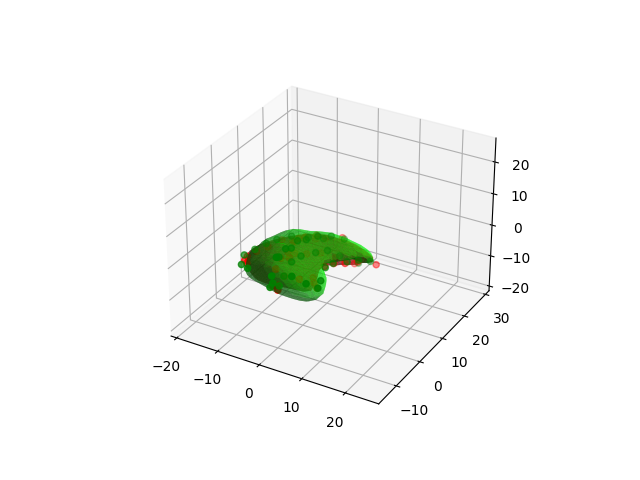

In [25]:
# draw them together
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
color = np.array([1.0,0.0,0.0])
Rn0 = get_face_normals(Rv0,f0)
mesh0_ = Poly3DCollection(Rv0[f0],color=color*(diffuse*np.clip(Rn0@direction,0,1) + ambient)[...,None],alpha=0.5,edgecolor='none')
ax.add_collection3d(mesh0_)

color = np.array([0.0,1.0,0.0])

mesh1_ = Poly3DCollection((v1-c1)[f1],color=color*(diffuse*np.clip(n1@direction,0,1) + ambient)[...,None],alpha=0.5,edgecolor='none')
ax.add_collection3d(mesh1_)

xlim,ylim,zlim = lim_from_v(np.concatenate((Rv0,v1)))
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)

ax.scatter(*Rq0.T,c='r')
ax.scatter(*(q1-c1).T,c='g')

In [26]:
ER = 0.5*np.sum((R@X-Y)**2)
print(f'Sum of square error after rotation {ER}')
# note this is between linear and translation

Sum of square error after rotation 49.77114244197702


# Splines

In [27]:
# after applying the best linear transform, we'll apply a spline transform
# set up X and Y as D X N arrays
X = np.copy(q0.T)
X = A[:3,:3]@X + A[:3,-1][...,None] # apply the affine transform we already estimated
Y = np.copy(q1.T)

# find a spline transform that aligns the data in X (affine transformed landmarks)
# to the data in Y (the target landmarks on the green surface)

# estimate our spline transform
scale = 10.0 # bigger for smoother, smaller for less smooth
# calculate the pairwise distance between all the points in X
d2 = np.sum( (X[:,None] - X[:,:,None])**2  ,0)
# define our gaussian kernel evaluated at all the pairwise distances
K = np.exp(-d2**2/2.0/scale**2) # specify a Gaussian kernel, 
# our displacement field is a linear combination of these gaussian blobs
# our goal is to estimate the coefficients in this linear combination

# regularization causes inexact matching
sigmaR = 1.0
P = np.linalg.solve(K + np.eye(K.shape[0])/sigmaR**2 , (Y-X).T).T
# estimate coefficients in linear combination
V = P@K # using matrix multiplication we estimate our displacement vectors
splineX = X + V # easy to apply this transformation to landmarks

In [28]:
# transform the data
splineq0 = splineX.T
# to apply the spline transform
# we need to compute pariwse distances between all our landmark points, and all our surface vertices
d2 = np.sum( (Av0.T[:,None] - X[:,:,None])**2  ,0)
# we then evaluate our kernel at these pariwise distances
K = np.exp(-d2**2/2.0/scale**2)
# take a linear combination of all these Gaussian blobs
V = P@K
splinev0 = (A[:3,:3]@v0.T + A[:3,-1][...,None]).T + V.T

<IPython.core.display.Javascript object>


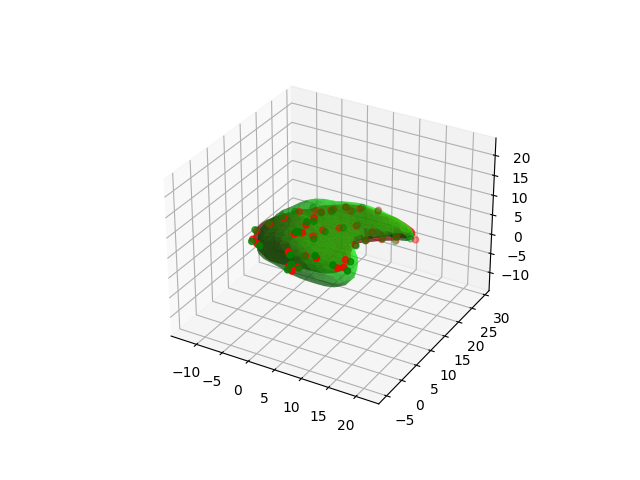

In [29]:
# draw them together
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
color = np.array([1.0,0.0,0.0])
splinen0 = get_face_normals(splinev0,f0)
mesh0_ = Poly3DCollection(splinev0[f0],color=color*(diffuse*np.clip(splinen0@direction,0,1) + ambient)[...,None],alpha=0.5,edgecolor='none')
ax.add_collection3d(mesh0_)

color = np.array([0.0,1.0,0.0])

mesh1_ = Poly3DCollection(v1[f1],color=color*(diffuse*np.clip(n1@direction,0,1) + ambient)[...,None],alpha=0.5,edgecolor='none')
ax.add_collection3d(mesh1_)

xlim,ylim,zlim = lim_from_v(np.concatenate((splinev0,v1)))
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)

ax.scatter(*splineq0.T,c='r')
ax.scatter(*q1.T,c='g')

In [30]:
Espline = 0.5*np.sum((splineX-Y)**2)
print(f'Sum of square error after spline {Espline}')


Sum of square error after spline 5.426329231515054


In [31]:
np.max(np.abs(V))

1.5228920007402946

# Transforming images

<IPython.core.display.Javascript object>


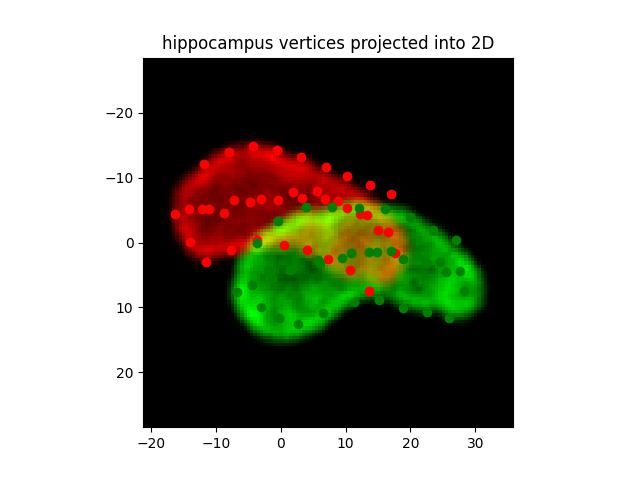

In [32]:
# make a quick image using the vertices
dx = 0.5
x0 = np.arange(xlimsave[0]-5,xlimsave[1]+5,dx)
x1 = np.arange(ylimsave[0]-5,ylimsave[1]+5,dx)
X_ = np.stack(np.meshgrid(x0,x1,indexing='ij'),-1)

I0 = np.zeros_like(X_[...,0])
blur = 2.0
for i in range(v0.shape[0]):
    I0 += np.exp( - np.sum((v0[i,:2]-X_)**2,-1)**2/blur**2  )
I0 /= np.max(I0)
    
I1 = np.zeros_like(X_[...,0])
for i in range(v1.shape[0]):
    I1 += np.exp( - np.sum((v1[i,:2]-X_)**2,-1)**2/blur**2  )
I1 /= np.max(I1)
    
extent = (x1[0]-dx/2, x1[-1]+dx/2, x0[-1]+dx/2, x0[0]-dx/2)    
fig,ax = plt.subplots()
ax.imshow(np.stack((I0,I1,I0*0),-1),extent=extent)
ax.set_title('hippocampus vertices projected into 2D')
ax.scatter(q0[:,1],q0[:,0],c='r')
ax.scatter(q1[:,1],q1[:,0],c='g')


In [33]:
# solve the same affine transformation problem in 2D
X = q0[:,:2].T
X = np.concatenate((X,np.ones((1,X.shape[-1])))) # homogeneous coordinates
Y = q1[:,:2].T
Y = np.concatenate((Y,np.ones((1,X.shape[-1]))))
A = (Y@X.T)@np.linalg.inv(X@X.T) # calculate pseudoinverse
print(A)

Asave = A

[[ 9.46269575e-01 -1.56643612e-01  8.60863610e+00]
 [ 1.65330899e-01  1.02670895e+00  1.08252430e+01]
 [-2.60208521e-17  4.33680869e-19  1.00000000e+00]]


<IPython.core.display.Javascript object>


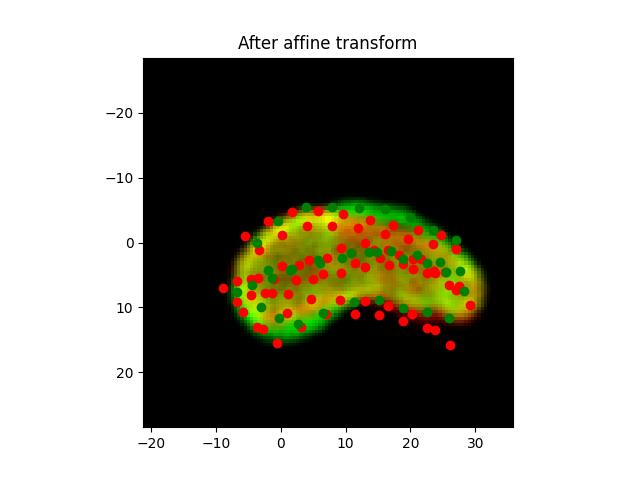

Text(0.5, 1.0, 'After affine transform')

In [34]:
# calculate the inverse transformation
Ai = np.linalg.inv(A)
# apply the inverse transform to our coordinate grid
AiX = (Ai[:2,:2]@X_[...,None])[...,0] + Ai[:2,-1]

# interpolate our image at this new set of points
from scipy.interpolate import interpn
AI0 = interpn([x0,x1],I0,AiX,bounds_error=False,fill_value=0.0)
fig,ax = plt.subplots()
ax.imshow(np.stack((AI0,I1,I0*0),-1),extent=extent)

Aq0 = (A[:2,:2]@q0[:,:2,None]) + A[:2,-1]
ax.scatter(Aq0[:,1],Aq0[:,0],c='r')
ax.scatter(q1[:,1],q1[:,0],c='g')
ax.set_title('After affine transform')

<IPython.core.display.Javascript object>


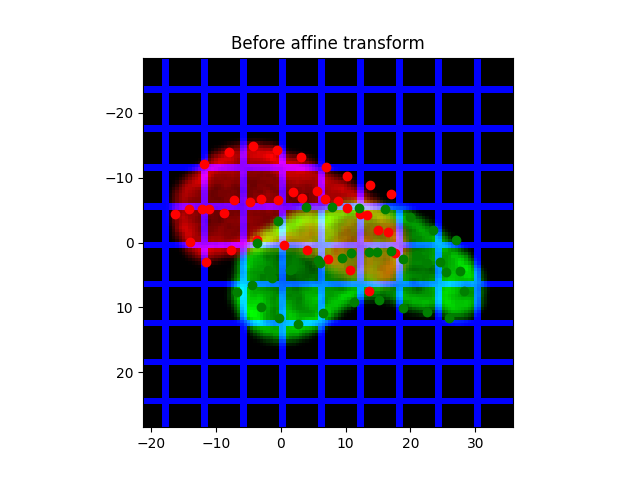

<IPython.core.display.Javascript object>


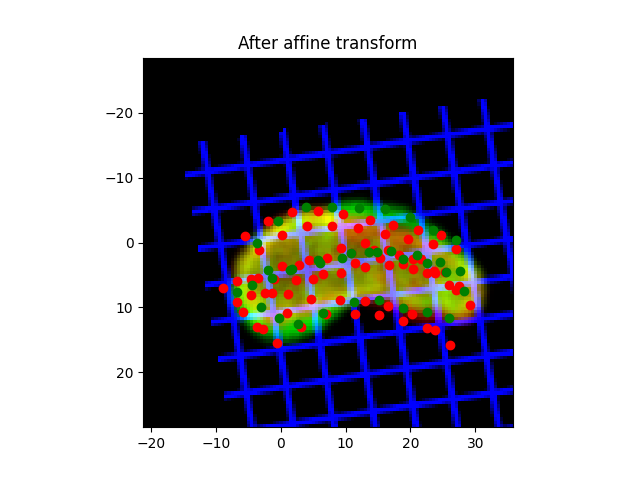

Text(0.5, 1.0, 'After affine transform')

In [35]:
# define a grid, we'll apply transformations to see how it deforms
period = 6.0 # period of 6 pixels
thickness = 2.0 # draw lines with a thickness of 2
I0_ = (X_[...,0]%period <= dx*thickness) + (X_[...,1]%period <= dx*thickness) 

# interpolate on exactly the same sample points as the red hippocmpus
AI0_ = interpn([x0,x1],I0_,AiX,bounds_error=False,fill_value=0.0)
fig,ax = plt.subplots()
ax.imshow(np.stack((I0,I1,I0_),-1),extent=extent)
ax.scatter(q0[:,1],q0[:,0],c='r')
ax.scatter(q1[:,1],q1[:,0],c='g')
ax.set_title('Before affine transform')


fig,ax = plt.subplots()
ax.imshow(np.stack((AI0,I1,AI0_),-1),extent=extent)
ax.scatter(Aq0[:,1],Aq0[:,0],c='r')
ax.scatter(q1[:,1],q1[:,0],c='g')
ax.set_title('After affine transform')

In [36]:
# after applying the best linear transform, we'll apply a spline transform
X = np.copy(q0[:,:2].T)
X = A[:2,:2]@X + A[:2,-1][...,None]
Y = np.copy(q1[:,:2].T)


scale = 20.0
d2 = np.sum( (X[:,None] - X[:,:,None])**2  ,0)
K = np.exp(-d2**2/2.0/scale**2)
sigmaR = 1e0
P = np.linalg.solve(K+ np.eye(K.shape[0])/sigmaR**2 , (Y-X).T).T
V = P@K
splineX = X + V

In [37]:
# transform the grid
# assume the inverse of the spline is x-v
d2 = np.sum( (X_.reshape(-1,2).T[:,None] - X[:,:,None])**2  ,0)
K = np.exp(-d2**2/2.0/scale**2)
V = P@K
Ai = np.linalg.inv(A)
splineX_ = (Ai[:2,:2]@(X_.reshape(-1,2) - V.T)[...,None])[...,0] + Ai[:2,-1]
splineX_ = splineX_.reshape(X_.shape)

In [38]:
splineI0_ = interpn([x0,x1],I0_,splineX_,bounds_error=False,fill_value=0.0)
splineI0 = interpn([x0,x1],I0,splineX_,bounds_error=False,fill_value=0.0)

<IPython.core.display.Javascript object>


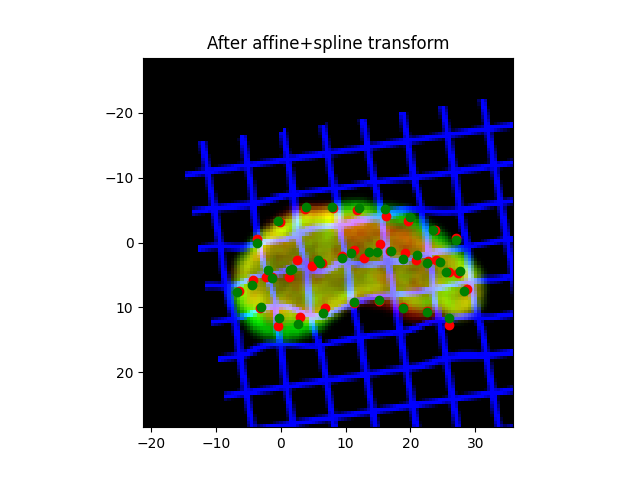

Text(0.5, 1.0, 'After affine+spline transform')

In [39]:
fig,ax = plt.subplots()
ax.imshow(np.stack((splineI0,I1,splineI0_),-1),extent=extent)
ax.scatter(splineX[1],splineX[0],c='r')
ax.scatter(q1[:,1],q1[:,0],c='g')
ax.set_title('After affine+spline transform')

# Affine image registration

Now we will align imaging data instead of labeled landmarks.

We will use torch to calculate gradients automatically, and build a simple gradient descent optimization algorithm just like we did for deep learning.

In [40]:
# convert or data to torch tensors
import torch
dtype = torch.float64 # in deep learning we mostly used float32.  
# here we need to calculate a lot of matrix inverses.  Sometimes float32 does not give us enough precision.
device = 'cpu'
Xt = torch.tensor(X_,device=device,dtype=dtype)
It = torch.tensor(I0,device=device,dtype=dtype)[None] # set first dimension for channels
Jt = torch.tensor(I1,device=device,dtype=dtype)[None]
gridt = torch.tensor(I0_,device=device,dtype=dtype)[None]

In [41]:
# define interpolation in torch, 
# we need to use built in functions so torch can automatically compute gradients for optimization
# using their slightly different "grid sample" function
def interp(XI,I,XS):
    # sample points get mapped to the interval -1 to 1
    XS = (XS - XI[0,0])/(XI[-1,-1] - XI[0,0])
    XS = XS*2-1    
    # torch expects xy order insteady of row column order
    # so we flip our sample points on the last axis
    # it expects us to have a minibatch dimension, so we use [None] to add a minibatch dimension of size 1
    # and we use [0] to remove this extra dimension
    return torch.nn.functional.grid_sample(I[None],XS.flip(-1)[None],align_corners=True)[0]

<IPython.core.display.Javascript object>


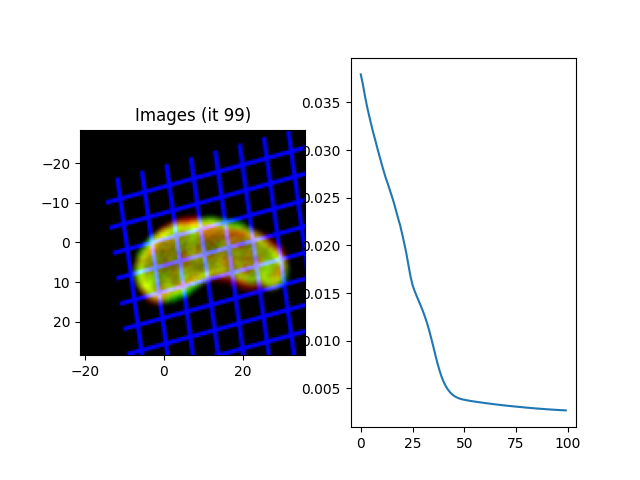

In [42]:
# define our variable to optimize over
# make sure you set requires_grad=True
A = torch.eye(3,device=device,dtype=dtype,requires_grad=True)

# create a figure so I can view transforming images interactively
fig,ax = plt.subplots(1,2)

# how many iterations of gradient descent
niter = 100
# what is our gradient descent step size
e = 1e-0
# save value of objective function at each iteration
Esave = []
# loop through iterations of gradient descent
for it in range(niter):
    # clear gradients
    # torch by default adds gradients instead of replacing them, so we have to set them to zero
    if A.grad is not None: A.grad.zero_()
        
    # compute the points to interpolate the image on (use A^{-1})
    Ai = torch.linalg.inv(A)
    Xs = (Ai[:2,:2]@Xt[...,None])[...,0] + Ai[:2,-1]
    
    # apply the transformation through interpolation
    AI = interp(Xt,It,Xs)
    
    # calculate the cost (here I used mean square error instead of sum of square error)
    E = 0.5*torch.mean( (AI-Jt)**2 )    
    Esave.append(E.item()) # save value of objective function for plotting
    
    # call this backward function to calculate gradients through backpropagation
    E.backward()
    
    # update parameters with gradient descent
    #A.data[:2] -= e*A.grad[:2]
    # notice, A.grad has values in the bottom row, which must always be 0,0,1 (for a homogeneous transform)
    # here I update only the top 2 rows of the matrix
    # the bottom row must always be 0,0,01    
    
    # notice, the linear part and translation part have different units, and will likely need different step sizes
    eL = 1e-0
    eT = 2e2
    A.data[:2,:2] -= eL*A.grad[:2,:2]
    A.data[:2,-1] -= eT*A.grad[:2,-1]
    
    with torch.no_grad():
        Agrid = interp(Xt,gridt,Xs)
        ax[0].cla()
        ax[0].imshow( torch.concatenate((AI,Jt,Agrid)).permute(1,2,0).cpu() , extent=extent)
        ax[0].set_title(f'Images (it {it})')
        
        ax[1].cla()
        ax[1].plot(Esave)
        fig.canvas.draw()

    

In [43]:
# compare the results
A,Asave

(tensor([[ 1.0618, -0.2848,  9.0166],
         [ 0.1506,  1.0260, 10.6253],
         [ 0.0000,  0.0000,  1.0000]], dtype=torch.float64, requires_grad=True),
 array([[ 9.46269575e-01, -1.56643612e-01,  8.60863610e+00],
        [ 1.65330899e-01,  1.02670895e+00,  1.08252430e+01],
        [-2.60208521e-17,  4.33680869e-19,  1.00000000e+00]]))

# Deformable image registration

We imaging that there is a gaussian blob sitting at every single pixel.

Every gaussian has a linear coefficient in front of it, which have called P (sometimes called momentum).

To evaluate the displacement field at every pixel on our grid, we have to compute a linear combination of all these Gaussians.

Take the convolution of our image P, with a Gaussian kernel.

<IPython.core.display.Javascript object>


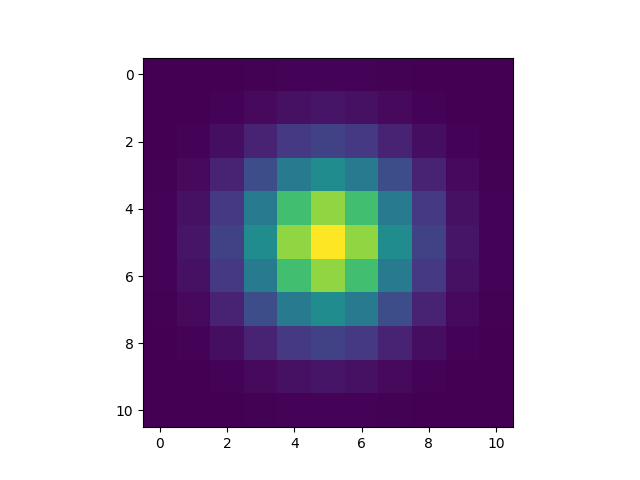

In [44]:
# smoothness kernel
r = 5
sigma = r/3
x = torch.arange(-r,r+1,device=device,dtype=dtype)
xgrid = torch.stack(torch.meshgrid(x,x,indexing='ij'),-1)
k = torch.exp( -torch.sum(xgrid**2,-1)/2.0/sigma**2  )
fig,ax = plt.subplots()
ax.imshow(k.cpu())
# torch uses the following convention
# it uses a "convolution layer" instead of the "convolution operation"
k = torch.eye(2,device=device,dtype=dtype)[...,None,None]*k[None,None]

<IPython.core.display.Javascript object>


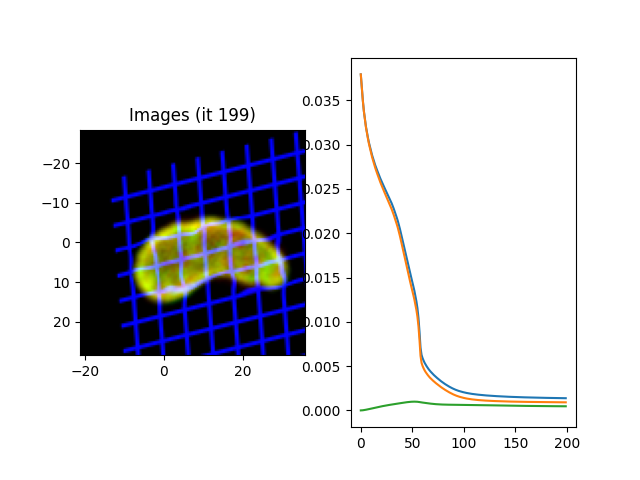

In [45]:
# initialize this variable p, say that it requires a gradient
p = torch.zeros_like(Xt,requires_grad=True)
# define our variable to optimize over
A = torch.eye(3,device=device,dtype=dtype,requires_grad=True)

fig,ax = plt.subplots(1,2)
niter = 200

eL = 1e-0
eT = 2e2

# stepsize parameter for our deformation
ep = 5e1
# regularizatoin parameter for our deformation 

sigmaR = 1e2
Esave = []
EMsave = []
ERsave = []
for it in range(niter):
    # clear gradients
    if A.grad is not None: A.grad.zero_()
    if p.grad is not None: p.grad.zero_()
    
    # first compute v (displacement field) from p (our momentum, coefficients in our linear combination
    # of gaussian blobs)
    # we need to swap "vector components" with "channel components" to use this function
    v = torch.nn.functional.conv2d(p.permute(-1,0,1),k,padding=r).permute(1,2,0)    
    
    # compute the points to interpolate the image on (use A^{-1})
    # using the "small deformation assumption", the inverse of our transform is just the negative of the displacement field
    Ai = torch.linalg.inv(A)
    Xs = (Ai[:2,:2]@(Xt-v)[...,None])[...,0] + Ai[:2,-1]
    
    # apply the transformation through interpolation
    AI = interp(Xt,It,Xs)
    
    # calculate the cost
    EM = 0.5*torch.mean( (AI-Jt)**2 )
    # new regularization cost function
    # since our kernel k, is the Green's function of our highpass operator LL in regularization
    # we can define the regularization energy as discussed in class
    # use a Riemann sum to approximate an integral
    # so we multiply by the area of a pixel dx**2
    ER = 0.5 * torch.sum( v*p  )/sigmaR**2*dx**2
    # total energy
    E = EM+ER
    Esave.append(E.item())
    ERsave.append(ER.item())
    EMsave.append(EM.item())
    
    # call the backward function to compute gradients
    E.backward()
    
    # update parameters with gradient descent    
    A.data[:2,:2] -= eL*A.grad[:2,:2] # the linear part
    A.data[:2,-1] -= eT*A.grad[:2,-1] # the translation part
    p.data -= ep*p.grad # coefficients in our linear combination of splines
    
    with torch.no_grad():
        Agrid = interp(Xt,gridt,Xs)
        ax[0].cla()
        ax[0].imshow( torch.concatenate((AI,Jt,Agrid)).permute(1,2,0).cpu() ,extent=extent)
        ax[0].set_title(f'Images (it {it})')
        
        ax[1].cla()
        ax[1].plot(Esave,label='E')
        ax[1].plot(EMsave,label='EM')
        ax[1].plot(ERsave,label='ER')
        fig.canvas.draw()

    

In [46]:
torch.max(torch.abs(v))

tensor(1.3997, dtype=torch.float64, grad_fn=<MaxBackward1>)

# Show that large splines are not invertible



In [47]:
# after applying the best linear transform, we'll apply a spline transform
A = Asave
X = np.copy(q0[:,:2].T)
X = A[:2,:2]@X + A[:2,-1][...,None]
Y = np.copy(q1[:,:2].T)


scale = 20.0
d2 = np.sum( (X[:,None] - X[:,:,None])**2  ,0)
K = np.exp(-d2**2/2.0/scale**2)
sigmaR = 1e0
P = np.linalg.solve(K+ np.eye(K.shape[0])/sigmaR**2 , (Y-X).T).T
V = P@K
splineX = X + V

<IPython.core.display.Javascript object>


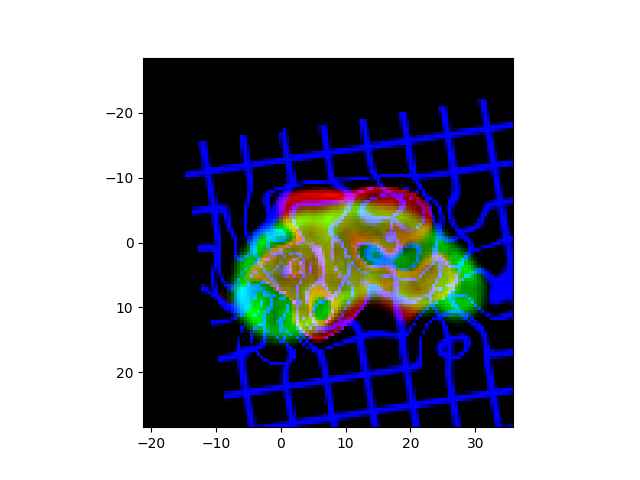

In [48]:
# transform the grid
# this is not right
d2 = np.sum( (X_.reshape(-1,2).T[:,None] - X[:,:,None])**2  ,0)
K = np.exp(-d2**2/2.0/scale**2)
V = P@K
Ai = np.linalg.inv(A)
spline_magnitude = 10.0
splineX_ = (Ai[:2,:2]@(X_.reshape(-1,2) - spline_magnitude*V.T)[...,None])[...,0] + Ai[:2,-1]
splineX_ = splineX_.reshape(X_.shape)

splineI0_ = interpn([x0,x1],I0_,splineX_,bounds_error=False,fill_value=0.0)
splineI0 = interpn([x0,x1],I0,splineX_,bounds_error=False,fill_value=0.0)

fig,ax = plt.subplots()
ax.imshow(np.stack((splineI0,I1,splineI0_),-1),extent=extent)

# Large Deformations
Since small and smooth deformations are always invertible, and the composition of two invertible transforms is convertible, we can build large invertible transforms by composing (interpolating) small ones.

In [49]:
def phi_from_v(X,v,n=5):
    # we can build an invertible small deformation
    # by composing a large deformation with itself multiple times
    # we'll compute a position field phi,
    # we initialze it to (id + v*constant)
    phi = X + v/2**n
    # this approach is caled scaling and squaring
    # scaling means we divide by 2**n
    # and square means we compose it with itself.
    for i in range(n-1):      
        # compose it with itself using interpolation
        phi = interp(X,phi.permute(-1,0,1),phi).permute(1,2,0)
    return phi

In [50]:
# after applying the best linear transform, we'll apply a spline transform
A = Asave
X = np.copy(q0[:,:2].T)
X = A[:2,:2]@X + A[:2,-1][...,None]
Y = np.copy(q1[:,:2].T)


d2 = np.sum( (X[:,None] - X[:,:,None])**2  ,0)
K = np.exp(-d2**2/2.0/scale**2)
P = np.linalg.solve(K+ np.eye(K.shape[0])/sigmaR**2 , (Y-X).T).T
V = P@K
splineX = X + V

<IPython.core.display.Javascript object>


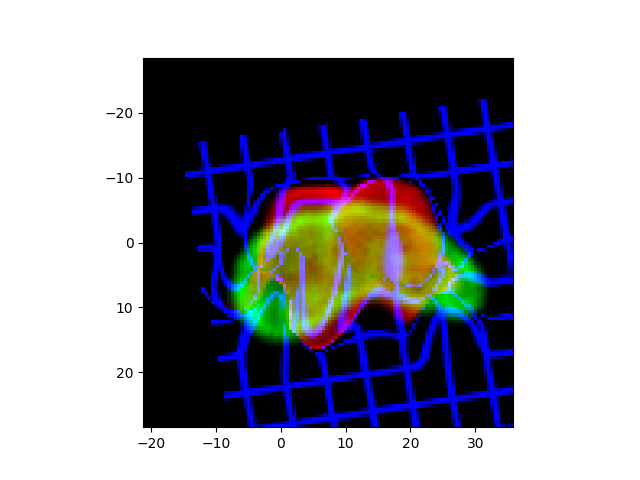

In [51]:
# transform the grid
# this is not right
d2 = np.sum( (X_.reshape(-1,2).T[:,None] - X[:,:,None])**2  ,0)
K = np.exp(-d2**2/2.0/scale**2)
V = P@K
Ai = np.linalg.inv(A)
spline_magnitude = 20.0

phi = phi_from_v(torch.tensor(X_),torch.tensor(-spline_magnitude*V.T.reshape(X_.shape)),n=10).numpy()

splineX_ = (Ai[:2,:2]@(phi)[...,None])[...,0] + Ai[:2,-1]


splineI0_ = interpn([x0,x1],I0_,splineX_,bounds_error=False,fill_value=0.0)
splineI0 = interpn([x0,x1],I0,splineX_,bounds_error=False,fill_value=0.0)

fig,ax = plt.subplots()
ax.imshow(np.stack((splineI0,I1,splineI0_),-1),extent=extent)

<IPython.core.display.Javascript object>


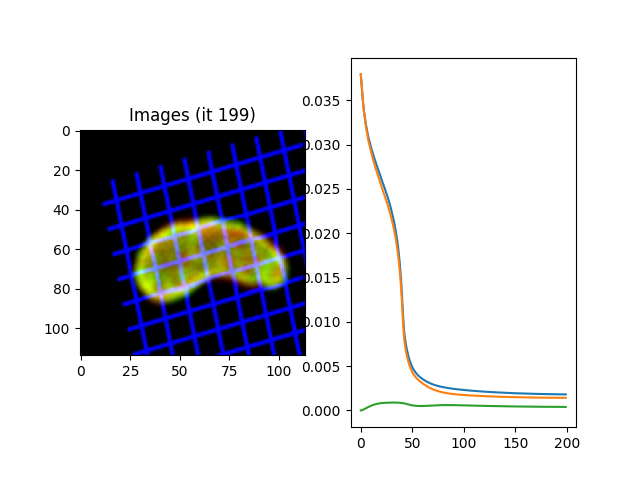

In [52]:
p = torch.zeros_like(Xt,requires_grad=True)
# define our variable to optimize over
A = torch.eye(3,device=device,dtype=dtype,requires_grad=True)

fig,ax = plt.subplots(1,2)
niter = 200
ep = 2e2
eL = 1e-0
eT = 2e2
sigmaR = 1e2
Esave = []
EMsave = []
ERsave = []
for it in range(niter):
    # clear gradients
    if A.grad is not None: A.grad.zero_()
    if p.grad is not None: p.grad.zero_()
    
    # first compute v from p
    # we need to swap "vector components" with "channel components" to use this function
    v = torch.nn.functional.conv2d(p.permute(-1,0,1),k,padding=r).permute(1,2,0)    
    
    # compute the points to interpolate the image on (use A^{-1})
    Ai = torch.linalg.inv(A)
    phi = phi_from_v(Xt,-v)
    # instead of writint Xt-v, we use the position field computed by scaling and squaring
    Xs = (Ai[:2,:2]@phi[...,None])[...,0] + Ai[:2,-1]
    
    # apply the transformation through interpolation
    AI = interp(Xt,It,Xs)
    
    # calculate the cost
    EM = 0.5*torch.mean( (AI-Jt)**2 )
    ER = 0.5 * torch.sum( v*p  )/sigmaR**2*dx**2
    E = EM+ER
    Esave.append(E.item())
    ERsave.append(ER.item())
    EMsave.append(EM.item())
    E.backward()
    
    # update parameters with gradient descent    
    A.data[:2,:2] -= eL*A.grad[:2,:2]
    A.data[:2,-1] -= eT*A.grad[:2,-1]
    p.data -= ep*p.grad
    
    with torch.no_grad():
        Agrid = interp(Xt,gridt,Xs)
        ax[0].cla()
        ax[0].imshow( torch.concatenate((AI,Jt,Agrid)).permute(1,2,0).cpu() )
        ax[0].set_title(f'Images (it {it})')
        
        ax[1].cla()
        ax[1].plot(Esave,label='E')
        ax[1].plot(EMsave,label='EM')
        ax[1].plot(ERsave,label='ER')
        fig.canvas.draw()

    

In [53]:
torch.max(torch.abs(v))

tensor(1.4745, dtype=torch.float64, grad_fn=<MaxBackward1>)

In [54]:
# look at the displacement of our position field
torch.max(torch.abs(phi-Xt))

tensor(0.7121, dtype=torch.float64, grad_fn=<MaxBackward1>)